# Evaluation of iCR models

In this notebook, we evaluate the models in detail and test the hypotheses proposed in the paper.

1. Overall performance of turn-level iCR models

- For all experiments, compute Average Precision, Binary F1 Score and Weighted-Average F1-Score in the validation and test sets.
- For Action-Takers, also compute Average Precision, Binary F1 Score per type of action.

2. Test H1

- Direct comparison of the overall results for the pertinent models. Done in the paper.

3. Test H2

- For the pure Action-Takers, compute classification margin and binary cross-entropy at turn-level and clipart-level.
- Compute the statistical significance tests.
- Is the classification margin (i.e. uncertainty) a good score/predictor for when to ask?

4. Overall performance of clipart-level iCR models

- Same as in 1. Done in the paper.

5. Test H3

- Same as in 2. Also consider the checkpointed models. Done in the paper.

### Further possibilities (TODO)

- eval by clipart, by attribute, by turn
- what turns with uncertainty have in common?
- is uncertainty more evident in iCR-Action-Maker, that was trained for that?
- uncertainty diff between CR turn and post iCR turn
- update sklearn?

In [1]:
import os
import random
import sys
from pathlib import Path
sys.path.append('..')

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import average_precision_score

from aux import (define_model_type, parse_metadata, get_test_epoch,
                 classification_margin, binary_cross_entropy,
                 define_experiment_name, read_predictions, read_gold, 
                 compute_main_metrics, read_action_predictions,
                 define_sorter)

sns.set(font='cmtt10', style="white", font_scale=1.2)

/home/users/blasota/anaconda3/envs/codraw_pl_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
OUT_DIR = Path("../outputs")

experiment_ids = os.listdir(OUT_DIR)

# we do not include the meta-label here to avoid inflating the performance
ACTION_TAKER_LABELS = ['action_presence', 'action_move', 'action_flip', 'action_size']#, 'action']

In [3]:
experiments = {}

for experiment in experiment_ids:
    path = OUT_DIR / experiment
    meta_file = path / 'meta.txt'

    # read the tag and the best epoch
    with open(meta_file, 'r') as file:
        line = file.readlines()[-1]
        assert 'Best' in line
        name, best_epoch = parse_metadata(line)
        best_epoch = int(best_epoch.strip('\n'))

    # define the type of model and naming
    with open(path / 'config.json', 'r') as file:
        config = json.load(file)
        model_type = define_model_type(config)
        new_name = define_experiment_name(config)
    
    if (config['full_trf_encoder']
            or config['n_epochs'] > 30
            or config['context_size'] != 3
            or 'context' in name):
        # we won't use these models in the paper analysis
        continue
    if new_name in experiments:
        raise KeyError
    experiments[new_name] = [best_epoch, experiment, model_type]

print(f'Loaded {len(experiments)} experiments.')

Loaded 49 experiments.


## Overall Performance

We first compute Average Performance, Binary F1 Score and Weighted-Average F1 Score for each experiment, in the validation and test sets.

For the Overhearer, we compute the score for the iCR label.
For the iCR-Action-Taker, we compute the score for the iCR label and the score over all action predictions.

In [4]:
results = {'iCR': {name : {} for name in experiments},
           'Acting': {name : {} for name in experiments}}

for name, (best_epoch, exp_id, model_type) in tqdm(experiments.items()):

    folder = OUT_DIR / exp_id

    if model_type != 'action_taker':
        for split in ('val', 'test'):

            epoch = best_epoch if split == 'val' else get_test_epoch(folder)

            prediction_type = 'icr_label' if model_type.startswith('turn') else 'icr_clip_label'
            preds = read_predictions(folder, epoch, split, prediction_type)

            gold_type = 'iCR' if model_type.startswith('turn') else 'icr_clip_label'
            gold = read_gold(folder, split, gold_type)
            merged = pd.concat([gold.set_index('identifier'),
                                preds.set_index('identifier')], axis=1) 

            labels = merged['label']
            scores = merged['prediction']
            ap, bf1, mf1 = compute_main_metrics(labels, scores)
            results['iCR'][name] |= {f'ap-{split}': ap,
                                     f'bf1-{split}': bf1,
                                     f'mf1-{split}': mf1}
    
    if 'action_taker' in model_type:
        for split in ('val', 'test'):
            joint = []
            for action_type in ACTION_TAKER_LABELS:

                epoch = best_epoch if split == 'val' else get_test_epoch(folder)
                
                preds = read_predictions(folder, epoch, split, action_type)
                gold = read_gold(folder, split, action_type)

                gold['position'] = pd.to_numeric(gold['position'])
                merged = pd.concat([gold.set_index(['identifier', 'position']),
                                    preds.set_index(['identifier', 'position'])], axis=1) 
                joint.append(merged)

                labels = merged['label']
                scores = merged['prediction']
                ap, bf1, mf1 = compute_main_metrics(labels, scores)
                results['Acting'][name] |= {f'ap-{split}-{action_type}': ap,
                                            f'bf1-{split}-{action_type}': bf1,
                                            f'mf1-{split}-{action_type}': mf1}
            
            # consider all action labels
            all_merged = pd.concat(joint, axis=0)

            labels = all_merged['label']
            scores = all_merged['prediction']
            ap, bf1, mf1 = compute_main_metrics(labels, scores)
            results['Acting'][name] |= {f'ap-{split}-all': ap,
                                        f'bf1-{split}-all': bf1,
                                        f'mf1-{split}-all': mf1}

100%|██████████| 49/49 [03:01<00:00,  3.71s/it]


In [5]:
icr_table = pd.DataFrame.from_dict(results['iCR'], orient='index')
actions_table = pd.DataFrame.from_dict(results['Acting'], orient='index')

full_df = pd.concat([icr_table, actions_table], axis=1)
full_df

,ap-val,bf1-val,mf1-val,ap-test,bf1-test,mf1-test,ap-val-action_presence,bf1-val-action_presence,mf1-val-action_presence,ap-val-action_move,...,mf1-test-action_move,ap-test-action_flip,bf1-test-action_flip,mf1-test-action_flip,ap-test-action_size,bf1-test-action_size,mf1-test-action_size,ap-test-all,bf1-test-all,mf1-test-all
"when#Overhearer#G, D, $S_b$, A",0.398670,0.394331,0.661563,0.379235,0.377922,0.654506,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"when#Overhearer#G, $S_b$, $S_a$",0.174497,0.140637,0.529081,0.144455,0.103367,0.511267,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"what#pretrained-iCR-Action-Taker#G, D, $S_b$, $L_A$",0.761379,0.708018,0.827236,0.743139,0.684300,0.812807,0.750832,0.712900,0.850424,0.495243,...,0.708230,0.156316,0.231579,0.615039,0.450550,0.453488,0.725776,0.630062,0.600982,0.796884
"what#pretrained-iCR-Action-Detecter#G, D, $S_b$, $S_a$",0.765743,0.716003,0.831434,0.733475,0.684116,0.811979,0.963025,0.907104,0.951830,0.529013,...,0.736486,0.198688,0.250000,0.624260,0.509917,0.486111,0.742294,0.834693,0.730298,0.862909
"what#pretrained-iCR-Action-Taker#G, D, $S_b$",0.764989,0.716101,0.831344,0.739906,0.681842,0.810912,0.739984,0.710760,0.849420,0.464113,...,0.706409,0.194484,0.312500,0.655571,0.441511,0.444444,0.721192,0.612355,0.592528,0.792589
"what#Overhearer#G, D, A",0.739276,0.691097,0.816374,0.711897,0.683621,0.810996,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"what#iCR-Action-Detecter#G, D, $S_b$, $S_a$, A",0.745036,0.690083,0.814005,0.722538,0.685017,0.809905,0.769368,0.679335,0.834213,0.415948,...,0.701032,0.081358,0.000000,0.499610,0.234658,0.248062,0.623033,0.651395,0.570000,0.781639
"when#iCR-Action-Detecter#G, D, $S_b$, $S_a$, $L_A$",0.447763,0.407258,0.671993,0.409788,0.366300,0.652426,0.974127,0.924956,0.961266,0.651586,...,0.794172,0.442807,0.490850,0.744877,0.641545,0.642494,0.820595,0.864232,0.777153,0.886949
"when#iCR-Action-Taker#G, D, $S_b$, $L_A$",0.418302,0.337368,0.637633,0.378892,0.311183,0.625679,0.866678,0.831909,0.913058,0.603005,...,0.780195,0.392294,0.426667,0.712785,0.542486,0.564953,0.781563,0.771528,0.709851,0.852650
"when#Overhearer#G, D, $S_b$",0.402791,0.273322,0.605407,0.372511,0.267483,0.604436,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create paper table:

In [6]:
halves = []
selected_cols = ['ap-test', 'bf1-test', 'mf1-test',
                 'ap-test-all', 'bf1-test-all', 'mf1-test-all']

for keyword in ('when', 'what'):
    sorter = define_sorter(keyword)

    paper_df = full_df[full_df.index.isin(sorter)].copy()
    paper_df.sort_index(key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
    paper_df = paper_df[selected_cols].reset_index(names='model')
    paper_df[['level', 'type', 'inputs']] = paper_df.model.str.split('#', expand=True)
    paper_df = paper_df.drop(['model'], axis=1)
    if keyword == 'what':
        paper_df['type'] = paper_df['type'].str.replace('pretrained-', '')
    paper_df.drop('level', axis=1, inplace=True)
    paper_df.set_index(['type', 'inputs'], inplace=True)

    halves.append(paper_df)

In [7]:
paper_df = pd.concat(halves, axis=1)
paper_df.insert(6, 'pad', ['']*paper_df.shape[0])
paper_df

ap-test  bf1-test  mf1-test  \
type                inputs                                                    
Overhearer          G                          0.138271  0.000000  0.470148   
                    G, D                       0.384272  0.349858  0.642214   
                    G, D, $S_b$                0.372511  0.267483  0.604436   
                    G, D, $S_b$, $S_a$         0.378839  0.304314  0.620852   
                    G, D, A                    0.372205  0.404444  0.662932   
                    G, D, $S_b$, A             0.379235  0.377922  0.654506   
                    G, D, $S_b$, $S_a$, A      0.388637  0.377585  0.655335   
Action-Taker        G                               NaN       NaN       NaN   
                    G, D                            NaN       NaN       NaN   
                    G, D, $S_b$                     NaN       NaN       NaN   
iCR-Action-Taker    G, D                       0.378966  0.393957  0.658971   
                    G, D, $L_A$                0.393274  0.372030  0.652906   
                    G, D, $S_b$                0.384744  0.380144  0.655962   
                    G, D, $S_b$, $L_A$         0.378892  0.311183  0.625679   
iCR-Action-Detecter G, D, $S_b$, $S_a$         0.416224  0.418868  0.676081   
                    G, D, $S_b$, $S_a$, $L_A$  0.409788  0.366300  0.652426   

                                               ap-test-all  bf1-test-all  \
type                inputs                                                 
Overhearer          G                                  NaN           NaN   
                    G, D                               NaN           NaN   
                    G, D, $S_b$                        NaN           NaN   
                    G, D, $S_b$, $S_a$                 NaN           NaN   
                    G, D, A                            NaN           NaN   
                    G, D, $S_b$, A                     NaN           NaN   
                    G, D, $S_b$, $S_a$, A              NaN           NaN   
Action-Taker        G                             0.149600      0.005178   
                    G, D                          0.769959      0.710968   
                    G, D, $S_b$                   0.762495      0.708095   
iCR-Action-Taker    G, D                          0.755789      0.702253   
                    G, D, $L_A$                   0.764671      0.708420   
                    G, D, $S_b$                   0.760952      0.702482   
                    G, D, $S_b$, $L_A$            0.771528      0.709851   
iCR-Action-Detecter G, D, $S_b$, $S_a$            0.859809      0.763966   
                    G, D, $S_b$, $S_a$, $L_A$     0.864232      0.777153   

                                               mf1-test-all pad   ap-test  \
type                inputs                                                  
Overhearer          G                                   NaN      0.332323   
                    G, D                                NaN      0.697689   
                    G, D, $S_b$                         NaN      0.697472   
                    G, D, $S_b$, $S_a$                  NaN      0.694920   
                    G, D, A                             NaN      0.711897   
                    G, D, $S_b$, A                      NaN      0.712642   
                    G, D, $S_b$, $S_a$, A               NaN      0.706334   
Action-Taker        G                              0.498896           NaN   
                    G, D                           0.853292           NaN   
                    G, D, $S_b$                    0.851829           NaN   
iCR-Action-Taker    G, D                           0.848760      0.753137   
                    G, D, $L_A$                    0.851988      0.751106   
                    G, D, $S_b$                    0.848929      0.739906   
                    G, D, $S_b$, $L_A$             0.852650      0.743139   
iCR-Action-Detecter G, D

In [8]:
crop = lambda x: str(x)[:5]  # https://stackoverflow.com/a/62435913
print(paper_df.to_latex(na_rep='-', float_format=crop))

\begin{tabular}{llrrrrrrlrrrrrr}
\toprule
                    &                           &  ap-test &  bf1-test &  mf1-test &  ap-test-all &  bf1-test-all &  mf1-test-all & pad &  ap-test &  bf1-test &  mf1-test &  ap-test-all &  bf1-test-all &  mf1-test-all \\
type & inputs &          &           &           &              &               &               &     &          &           &           &              &               &               \\
\midrule
Overhearer & G &    0.138 &       0.0 &     0.470 &            - &             - &             - &     &    0.332 &     0.289 &     0.593 &            - &             - &             - \\
                    & G, D &    0.384 &     0.349 &     0.642 &            - &             - &             - &     &    0.697 &     0.665 &     0.801 &            - &             - &             - \\
                    & G, D, \$S\_b\$ &    0.372 &     0.267 &     0.604 &            - &             - &             - &     &    0.697 &     0.666 &    

/tmp/ipykernel_1908685/3521630445.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(paper_df.to_latex(na_rep='-', float_format=crop))


## Error Analysis

In [9]:
selected_cols = ['ap-test-action_presence', 'ap-test-action_move', 'ap-test-action_flip', 'ap-test-action_size']
actions_df = full_df[selected_cols].loc[['no-full#Action-Taker#G, D', 'when#iCR-Action-Taker#G, D',
                            'no-full#Action-Detecter#G, D, $S_b$, $S_a$', 'when#iCR-Action-Detecter#G, D, $S_b$, $S_a$']]

actions_df 


,ap-test-action_presence,ap-test-action_move,ap-test-action_flip,ap-test-action_size
"no-full#Action-Taker#G, D",0.875893,0.617186,0.367031,0.531992
"when#iCR-Action-Taker#G, D",0.865138,0.600694,0.398677,0.539263
"no-full#Action-Detecter#G, D, $S_b$, $S_a$",0.976898,0.644582,0.414817,0.636641
"when#iCR-Action-Detecter#G, D, $S_b$, $S_a$",0.974490,0.642672,0.423780,0.626966


In [10]:
print(actions_df .to_latex(float_format=crop))

\begin{tabular}{lrrrr}
\toprule
{} &  ap-test-action\_presence &  ap-test-action\_move &  ap-test-action\_flip &  ap-test-action\_size \\
\midrule
no-full\#Action-Taker\#G, D                   &                    0.875 &                0.617 &                0.367 &                0.531 \\
when\#iCR-Action-Taker\#G, D                  &                    0.865 &                0.600 &                0.398 &                0.539 \\
no-full\#Action-Detecter\#G, D, \$S\_b\$, \$S\_a\$  &                    0.976 &                0.644 &                0.414 &                0.636 \\
when\#iCR-Action-Detecter\#G, D, \$S\_b\$, \$S\_a\$ &                    0.974 &                0.642 &                0.423 &                0.626 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1908685/1061646559.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(actions_df .to_latex(float_format=crop))


## Test H2

Here, we do the analysis on the meta-action label (a label that is 1 whenever any action is performed on a clipart).

In [11]:
MODEL = 'no-full#Action-Taker#G, D'
SPLIT = 'test'

best_epoch, exp_id, model_type = experiments[MODEL]
folder = OUT_DIR / exp_id

ACTION = 'action'
REMOVE_META = False

***********    Results for test split on icr_clip_label   ***********

AP of loss scores:  0.05364341965677968
AP of margin scores:  0.009554616845343386

Loss (mean):	  {'loss_icr=0': 0.06847468739957975, 'loss_icr=1': 0.3049727541611761}
Loss (std):	  {'loss_icr=0': 0.35644073744641, 'loss_icr=1': 0.8093502157411824}

Certainty (mean):	  {'margin_icr=0': 0.9527807284661945, 'margin_icr=1': 0.8382407800651626}
Certainty (std):	  {'margin_icr=0': 0.14777424968905817, 'margin_icr=1': 0.25150370264186644}

Kolmogorov-Smirnoff test
Certainty: 	 stat= 0.5246704998328678 (p=0.0)
Loss: 	 stat= 0.5261352896287529 (p=0.0)



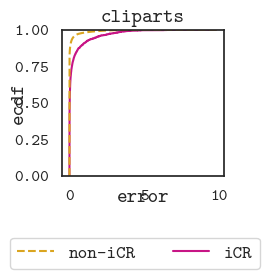

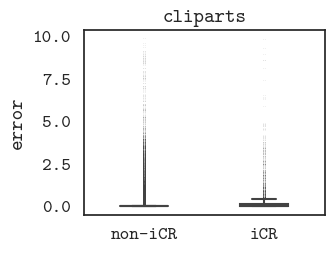

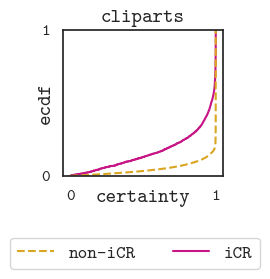

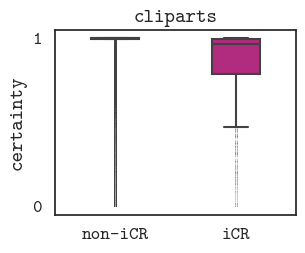

***********    Results for test split on icr_turn_label   ***********

AP of loss scores:  0.1414508768834172
AP of margin scores:  0.08018473324261247

Loss (mean):	  {'loss_icr=0': 7.474326781486889e-05, 'loss_icr=1': 8.054125837179995e-05}
Loss (std):	  {'loss_icr=0': 5.582872965323865e-05, 'loss_icr=1': 3.9321184656924204e-05}

Certainty (mean):	  {'margin_icr=0': 0.5252889502395791, 'margin_icr=1': 0.363083700543596}
Certainty (std):	  {'margin_icr=0': 0.32860242265018647, 'margin_icr=1': 0.2830033357452721}

Kolmogorov-Smirnoff test
Certainty: 	 stat= 0.21912280613451848 (p=5.361928945550622e-33)
Loss: 	 stat= 0.103810837246681 (p=1.0682465078271656e-07)



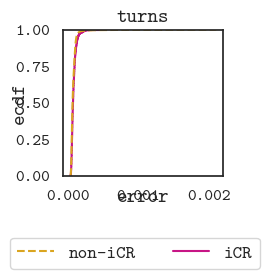

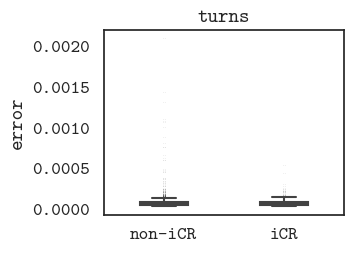

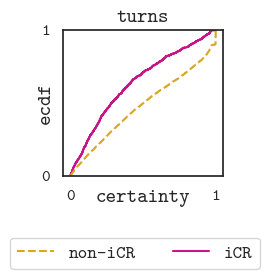

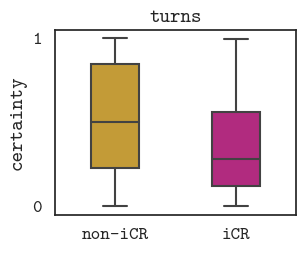

In [12]:
for title, LABEL in zip (['cliparts', 'turns'], ['icr_clip_label', 'icr_turn_label']):

    print(f'***********    Results for {SPLIT} split on {LABEL}   ***********')

    epoch = best_epoch if SPLIT == 'val' else get_test_epoch(folder)
    data_df, icr_turn_gold = read_action_predictions(folder, epoch, SPLIT)

    if ACTION != 'all':
        # filter only one type of action
        data_df = data_df[data_df['name'] == ACTION].copy()
    if REMOVE_META:
        # ignore the meta "any action" predictions
        assert ACTION != 'action'
        data_df = data_df[data_df['name'] != 'action'].copy()             

    # compute the scores
    data_df['margin'] = classification_margin(data_df['prediction'])
    data_df['loss'] = binary_cross_entropy(data_df['prediction'], data_df['label'])

    if LABEL == 'icr_turn_label':
        # for when to ask, we need to merge the predictions for all cliparts at a given
        # turn; we use the minimum, but mean or sum would also be possible
        icr_part = icr_turn_gold.drop('name', axis=1).set_index(['identifier', 'game_id', 'turn']).copy()
        summed_part = (data_df
                    .reset_index()
                    .drop(['clipart', 'name', 'position', 'label', 'prediction', 'icr_clip_label'], axis=1)
                    .groupby(['identifier', 'game_id', 'turn'])
                    .min()
                    .copy())
        data_df = pd.concat([summed_part, icr_part], axis=1)   

    # compute average precision using loss and certainty as a score
    ap_loss = average_precision_score(data_df[LABEL], data_df['loss'])
    ap_margin = average_precision_score(data_df[LABEL], data_df['margin'])
    print('\nAP of loss scores: ', ap_loss)
    print('AP of margin scores: ', ap_margin)

    # check the mean and std values for loss and certainty
    diffs_loss = data_df.groupby(LABEL).mean(numeric_only=True)['loss'].to_dict()
    diffs_loss = {f'loss_icr={k}': v for k, v in diffs_loss.items()}
    print('\nLoss (mean):\t ', diffs_loss)

    diffs_loss = data_df.groupby(LABEL).std(numeric_only=True)['loss'].to_dict()
    diffs_loss = {f'loss_icr={k}': v for k, v in diffs_loss.items()}
    print('Loss (std):\t ', diffs_loss)

    diffs_margin = data_df.groupby(LABEL).mean(numeric_only=True)['margin'].to_dict()
    diffs_margin = {f'margin_icr={k}': v for k, v in diffs_margin.items()}
    print('\nCertainty (mean):\t ', diffs_margin)

    diffs_margin = data_df.groupby(LABEL).std(numeric_only=True)['margin'].to_dict()
    diffs_margin = {f'margin_icr={k}': v for k, v in diffs_margin.items()}
    print('Certainty (std):\t ', diffs_margin)

    # compute the Kolmogorov-Smirnov test
    margin_icr = data_df.loc[data_df[LABEL] == 1]['margin'].tolist()
    margin_other = data_df.loc[data_df[LABEL] == 0]['margin'].tolist()

    loss_icr = data_df.loc[data_df[LABEL] == 1]['loss'].tolist()
    loss_other = data_df.loc[data_df[LABEL] == 0]['loss'].tolist()

    print('\nKolmogorov-Smirnoff test')
    res = scipy.stats.ks_2samp(margin_icr, margin_other, alternative='two-sided')
    print(f'Certainty: \t stat= {res.statistic} (p={res.pvalue})')

    res = scipy.stats.ks_2samp(loss_icr, loss_other, alternative='two-sided')
    print(f'Loss: \t stat= {res.statistic} (p={res.pvalue})\n')

    data_df[LABEL] = data_df[LABEL].replace({0: f'non-iCR', 1: f'iCR'})

    # plots
    for score in ['loss', 'margin']:
        scorelabel = 'certainty' if score == 'margin' else 'error' 

        # plot the cumulative distribution
        fig, ax = plt.subplots(figsize=(2.5, 2.4))
        g = sns.ecdfplot(data_df, x=score, hue=LABEL, palette=['goldenrod', 'mediumvioletred'], ax=ax)
        g.legend_.set_title('')
        plt.xlabel(scorelabel, labelpad=-10)
        plt.ylabel('ecdf', labelpad=-10)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.title(title)
        plt.tight_layout()
        sns.move_legend(ax, "lower center", bbox_to_anchor=(0.45, -0.7), ncol=2)
        for lines, linestyle, legend_handle in zip(ax.lines[::-1], ['--', '-'], ax.legend_.legend_handles):
            lines.set_linestyle(linestyle)
            legend_handle.set_linestyle(linestyle)
        if score == 'margin':
            ax.set_yticks([0, 1])
            ax.set_xticks([0, 1])
            plt.savefig(f'./figures/cdf-{LABEL}-{scorelabel}.pdf', bbox_inches='tight')
        plt.show()

        # plot the distribution
        fig, ax = plt.subplots(figsize=(3.1, 2.4))
        sns.boxplot(data_df, y=score, x=LABEL, dodge=True, fliersize=0.001, width=0.4,
                    palette=['goldenrod', 'mediumvioletred'], ax=ax)
        plt.ylabel(scorelabel)
        plt.xlabel('')
        plt.title(title)
        if score == 'margin':
            ax.set_yticks([0, 1])
            plt.savefig(f'./figures/boxplot-{LABEL}-{scorelabel}.pdf', bbox_inches='tight')
        plt.show()

In [13]:
"""
data_df[LABEL] = data_df[LABEL].replace({0: 'non iCR turns', 1: 'iCR turns'})

fig, ax = plt.subplots(figsize=(4.1, 3.4))
g = sns.ecdfplot(data_df, x='margin', hue=LABEL, palette=['goldenrod', 'mediumvioletred'], ax=ax)
g.legend_.set_title('')
plt.xlabel('certainty')
plt.ylabel('cumulative distribution')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

for lines, linestyle, legend_handle in zip(ax.lines[::-1], ['--', '-'], ax.legend_.legend_handles):
    lines.set_linestyle(linestyle)
    legend_handle.set_linestyle(linestyle)

#plt.savefig(f'./figures/cdf-{LABEL}.pdf', bbox_inches='tight')
plt.show()
"""

"\ndata_df[LABEL] = data_df[LABEL].replace({0: 'non iCR turns', 1: 'iCR turns'})\n\nfig, ax = plt.subplots(figsize=(4.1, 3.4))\ng = sns.ecdfplot(data_df, x='margin', hue=LABEL, palette=['goldenrod', 'mediumvioletred'], ax=ax)\ng.legend_.set_title('')\nplt.xlabel('certainty')\nplt.ylabel('cumulative distribution')\nax.tick_params(axis='both', which='major', labelsize=12)\nplt.tight_layout()\n\nfor lines, linestyle, legend_handle in zip(ax.lines[::-1], ['--', '-'], ax.legend_.legend_handles):\n    lines.set_linestyle(linestyle)\n    legend_handle.set_linestyle(linestyle)\n\n#plt.savefig(f'./figures/cdf-{LABEL}.pdf', bbox_inches='tight')\nplt.show()\n"